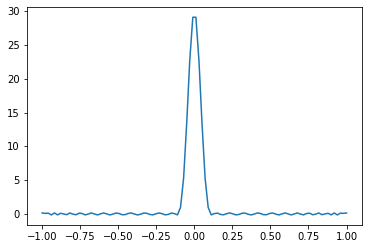

In [83]:
from scipy.special import eval_chebyt
import numpy as np
import matplotlib.pyplot as plt

k = 30
delta = 0.1

def filter_func(x, delta, k):
    val = 0
    for i in range(k):
        arg = -1 + 2*(x**2-delta**2/(1-delta**2))
        topk = eval_chebyt(k, arg)
        arg = -1 + 2*(-delta**2/(1-delta**2))
        botk = eval_chebyt(k, arg)
        val += topk/botk
    return val

xs = np.linspace(-1, 1, 100)

ys = np.zeros(len(xs))

for i, x in enumerate(xs):
    ys[i] = filter_func(x, delta, k)

plt.plot(xs, ys)


In [84]:
# phases below are calculated using QSPPACK for n=30, delta = 0.1
phases = [7.8306e-01, 1.4358e-03, -1.8554e-03, 2.3385e-03, -2.8875e-03, 3.5036e-03, -4.1874e-03, 4.9383e-03, -5.7547e-03, 6.6338e-03,
          -7.5717e-03, 8.5633e-03, -9.6021e-03, 1.0681e-02, -1.1790e-02, 1.2922e-02, -1.4064e-02, 1.5205e-02, -1.6334e-02, 1.7437e-02,
          -1.8501e-02, 1.9515e-02, -2.0463e-02, 2.1335e-02, -2.2117e-02, 2.2800e-02, -2.3373e-02, 2.3827e-02, -2.4157e-02, 2.4357e-02,
          -2.4424e-02, 2.4357e-02, -2.4157e-02, 2.3827e-02, -2.3373e-02, 2.2800e-02, -2.2117e-02, 2.1335e-02, -2.0463e-02, 1.9515e-02,
          -1.8501e-02, 1.7437e-02, -1.6334e-02, 1.5205e-02, -1.4064e-02, 1.2922e-02, -1.1790e-02, 1.0681e-02, -9.6021e-03, 8.5633e-03,
          -7.5717e-03, 6.6338e-03, -5.7547e-03, 4.9383e-03, -4.1874e-03, 3.5036e-03, -2.8875e-03, 2.3385e-03, -1.8554e-03, 1.4358e-03,
          7.8306e-01]

Let's start by getting the first excited state

In [85]:
from openfermion import get_sparse_operator
import numpy as np

from tangelo.linq import Circuit, Gate, get_backend
from tangelo.toolboxes.circuits.qsp import get_qsp_circuit_no_anc
from tangelo.toolboxes.circuits.lcu import get_uprep_uselect, get_lcu_qubit_op_info
from tangelo.molecule_library import mol_H2_sto3g
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.linq.helpers.circuits.statevector import StateVector

fe_op = mol_H2_sto3g.fermionic_hamiltonian
qu_op = fermion_to_qubit_mapping(fe_op, "scbk", n_spinorbitals=4, n_electrons=2)

ham = get_sparse_operator(qu_op).toarray()
eigs, vecs = np.linalg.eigh(ham)
alpha = eigs[3]-eigs[0]
lamb = eigs[1]

qu_op_tilde = (qu_op - lamb)/(alpha+abs(lamb))

init_state = np.random.random(4)
init_state /= np.linalg.norm(init_state)

sv = StateVector(init_state)
init_circ = sv.initializing_circuit()


In [86]:
qu_op_qs, m_qs, alpha = get_lcu_qubit_op_info(qu_op_tilde)
uprep, uselect, qu_op_qs, m_qs, alpha = get_uprep_uselect(qu_op_tilde)
cua = uprep + uselect + uprep.inverse()
eig_filt_circ = get_qsp_circuit_no_anc(cua, m_qs, phases)

In [87]:
full_circuit = init_circ + eig_filt_circ + Circuit([Gate("MEASURE", m) for m in m_qs])
full_circuit += Circuit([Gate("MEASURE", m_qs[-1]+1)])

In [88]:
sim = get_backend("qulacs")

f, sv = sim.simulate(full_circuit, desired_meas_result="0000", return_statevector=True)
sv = np.reshape(sv, (2**4, 4))[0, :]
sv = np.reshape(sv, (2,2)).T.flatten()

In [89]:
print(f'initial overlap = {abs(np.dot(vecs[:,1], init_state))}')
print(f'final overlap = {abs(np.dot(vecs[:,1], sv))}')

initial overlap = 0.11941071942277898
final overlap = 0.9996489313292234


Now lets get state 2

In [90]:
lamb = eigs[2]
qu_op_tilde = (qu_op - lamb)/(alpha+abs(lamb))

qu_op_qs, m_qs, alpha = get_lcu_qubit_op_info(qu_op_tilde)
uprep, uselect, qu_op_qs, m_qs, alpha = get_uprep_uselect(qu_op_tilde)
cua = uprep + uselect + uprep.inverse()
eig_filt_circ = get_qsp_circuit_no_anc(cua, m_qs, phases)

In [91]:
full_circuit = init_circ + eig_filt_circ + Circuit([Gate("MEASURE", m) for m in m_qs])
full_circuit += Circuit([Gate("MEASURE", m_qs[-1]+1)])

In [92]:
sim = get_backend("qulacs")

f, sv = sim.simulate(full_circuit, desired_meas_result="0000", return_statevector=True)
sv = np.reshape(sv, (2**4, 4))[0, :]
sv = np.reshape(sv, (2,2)).T.flatten()

In [93]:
print(f'initial overlap = {abs(np.dot(vecs[:,2], init_state))}')
print(f'final overlap = {abs(np.dot(vecs[:,2], sv))}')

initial overlap = 0.8594694189014058
final overlap = 0.9999961396095338
